In [57]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, save_model

from sklearn.metrics import classification_report, confusion_matrix

%config InlineBackend.figure_format = 'svg'

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
tf.test.is_built_with_gpu_support()

True

In [2]:
data_dir = 'Pest/pest/'

In [3]:
os.listdir(data_dir)

['test', 'train']

In [8]:
test_path = data_dir + 'test/'
train_path = data_dir + 'train/'

In [9]:
os.listdir(test_path)

['aphids',
 'armyworm',
 'beetle',
 'bollworm',
 'grasshopper',
 'mites',
 'mosquito',
 'sawfly',
 'stem_borer']

In [10]:
os.listdir(train_path)

['aphids',
 'armyworm',
 'beetle',
 'bollworm',
 'grasshopper',
 'mites',
 'mosquito',
 'sawfly',
 'stem_borer']

In [11]:
os.listdir(train_path + 'aphids')[0]

'jpg_0 - Copy (3).jpg'

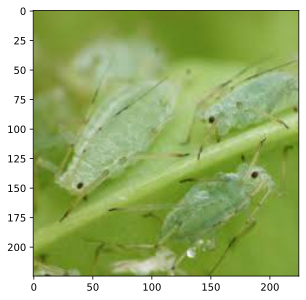

In [12]:
para_cell = (train_path + 'aphids\\' + 'jpg_0 - Copy (3).jpg')
plt.imshow(imread(para_cell))

In [13]:
os.listdir(train_path + 'armyworm')[0]

'jpg_0 - Copy (2).jpg'

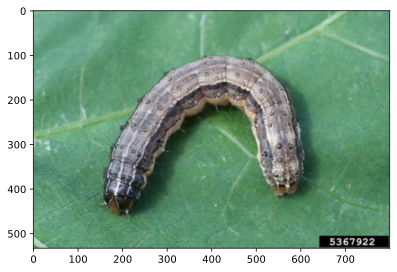

In [14]:
para_cell = (train_path + 'armyworm\\' + 'jpg_0 - Copy (2).jpg')
plt.imshow(imread(para_cell))

In [15]:
for i in os.listdir(train_path):
    print(f'{i}: {len(os.listdir(train_path + i))}')

aphids: 300
armyworm: 300
beetle: 300
bollworm: 300
grasshopper: 300
mites: 300
mosquito: 300
sawfly: 300
stem_borer: 300


In [16]:
for i in os.listdir(test_path):
    print(f'{i}: {len(os.listdir(test_path + i))}')

aphids: 50
armyworm: 50
beetle: 50
bollworm: 50
grasshopper: 50
mites: 50
mosquito: 50
sawfly: 50
stem_borer: 50


In [17]:
dim1 = []
dim2 = []

for i in os.listdir(test_path):
    for image_filename in os.listdir(test_path + i):
        img = imread(test_path + i + '\\' + image_filename)

        d1, d2, colors = img.shape
        dim1.append(d1)
        dim2.append(d2)

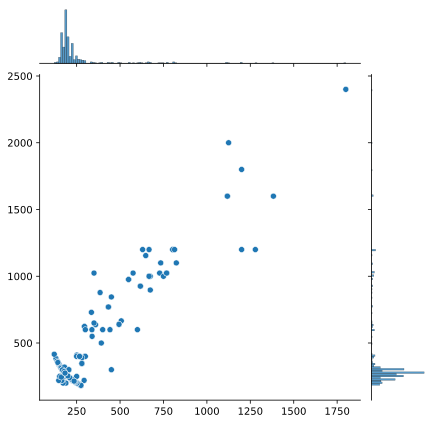

In [21]:
sns.jointplot(x = dim1, y = dim2)

In [22]:
np.mean(dim1)

247.84444444444443

In [23]:
np.mean(dim2)

348.4533333333333

In [17]:
IMG_SHAPE = (256, 256, 3)

In [19]:
250 * 350 * 3

262500

In [19]:
image_gen = ImageDataGenerator(rotation_range = 20, 
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               rescale = 1 / 255,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')


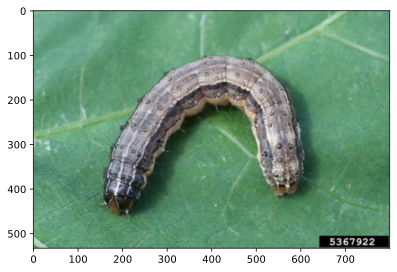

In [20]:
para_img = imread(para_cell)
plt.imshow(para_img)

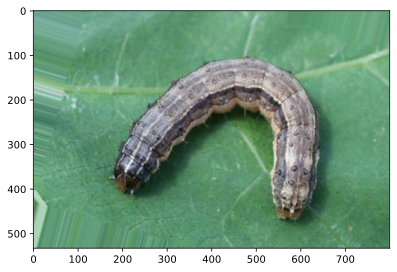

In [21]:
plt.imshow(image_gen.random_transform(para_img))

In [22]:
image_gen.flow_from_directory(train_path)

Found 2700 images belonging to 9 classes.


In [23]:
image_gen.flow_from_directory(test_path)

Found 450 images belonging to 9 classes.


In [27]:
BATCH_SIZE = 16

In [28]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size = IMG_SHAPE[:2],
                                                color_mode = 'rgb',
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'sparse',
                                                shuffle = True)

Found 2700 images belonging to 9 classes.


In [29]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size = IMG_SHAPE[:2],
                                                color_mode = 'rgb',
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'sparse',
                                                shuffle = False)

Found 450 images belonging to 9 classes.


In [30]:
train_image_gen.class_indices

{'aphids': 0,
 'armyworm': 1,
 'beetle': 2,
 'bollworm': 3,
 'grasshopper': 4,
 'mites': 5,
 'mosquito': 6,
 'sawfly': 7,
 'stem_borer': 8}

**`-1- Custom Model`**
---------------------------------------

In [33]:
model = Sequential()

model.add(Conv2D(filters = 256, kernel_size = (3, 3), input_shape = IMG_SHAPE, activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 512, kernel_size = (3, 3), input_shape = IMG_SHAPE, activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 512, kernel_size = (3, 3), input_shape = IMG_SHAPE, activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 512, kernel_size = (3, 3), input_shape = IMG_SHAPE, activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(9, activation = 'softmax'))

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 348, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 174, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 172, 512)     1180160   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 86, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 84, 512)       2359808   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 42, 512)      0

In [25]:
from tensorflow.keras.callbacks import EarlyStopping 

In [26]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [41]:
results = model.fit(train_image_gen, epochs = 20, 
                              validation_data = test_image_gen,
                              callbacks = [early_stop])

C:\Users\subhr\AppData\Local\Temp\ipykernel_13748\3241964666.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_image_gen, epochs = 20,


Epoch 1/20


KeyboardInterrupt: 

**`-2- AlexNet5 Model`**
---------------------------------------

In [148]:
# 8 Layer Model: 5 Convolution Layers with non-increasing kernel size and 3 fully connnected layers
AlexNetModel = Sequential()

AlexNetModel.add(Conv2D(filters = 96, kernel_size = (11, 11), strides=(4, 4), activation = 'relu', input_shape = IMG_SHAPE)),
AlexNetModel.add(BatchNormalization()),
AlexNetModel.add(MaxPool2D(pool_size=(3,3), strides=(2,2))),

AlexNetModel.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")),
AlexNetModel.add(BatchNormalization()),
AlexNetModel.add(MaxPool2D(pool_size=(3,3), strides=(2,2))),

AlexNetModel.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")),
AlexNetModel.add(BatchNormalization()),
AlexNetModel.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")),
AlexNetModel.add(BatchNormalization()),

AlexNetModel.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")),
AlexNetModel.add(BatchNormalization()),
AlexNetModel.add(MaxPool2D(pool_size=(3,3), strides=(2,2))),

AlexNetModel.add(Flatten()),

AlexNetModel.add(Dense(4096, activation='relu')),
AlexNetModel.add(Dropout(0.5)),

AlexNetModel.add(Dense(4096, activation='relu')),
AlexNetModel.add(Dropout(0.5)),

AlexNetModel.add(Dense(9, activation='softmax'))

AlexNetModel.compile(loss='sparse_categorical_crossentropy', optimizer = tf.optimizers.SGD(learning_rate = 0.001), metrics = ['accuracy'])
AlexNetModel.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 60, 85, 96)        34944     
                                                                 
 batch_normalization_20 (Bat  (None, 60, 85, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 29, 42, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 29, 42, 256)       614656    
                                                                 
 batch_normalization_21 (Bat  (None, 29, 42, 256)      1024      
 chNormalization)                                                
                                                     

In [149]:
results = AlexNetModel.fit_generator(train_image_gen, epochs = 50, 
                              validation_data = test_image_gen,
                              callbacks = [early_stop])

C:\Users\subhr\AppData\Local\Temp\ipykernel_7536\3493432835.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = AlexNetModel.fit_generator(train_image_gen, epochs = 50,


Epoch 1/50
85/85 [==============================] - 186s 2s/step - loss: 3.6112 - accuracy: 0.1737 - val_loss: 2.2100 - val_accuracy: 0.1133
Epoch 2/50
85/85 [==============================] - 196s 2s/step - loss: 2.7762 - accuracy: 0.2326 - val_loss: 2.1581 - val_accuracy: 0.1933
Epoch 3/50
85/85 [==============================] - 200s 2s/step - loss: 2.4527 - accuracy: 0.2744 - val_loss: 2.0663 - val_accuracy: 0.2378
Epoch 4/50
85/85 [==============================] - 208s 2s/step - loss: 2.2026 - accuracy: 0.3030 - val_loss: 1.8541 - val_accuracy: 0.3022
Epoch 5/50
85/85 [==============================] - 207s 2s/step - loss: 2.0845 - accuracy: 0.3211 - val_loss: 1.7067 - val_accuracy: 0.3733
Epoch 6/50
85/85 [==============================] - 204s 2s/step - loss: 1.9205 - accuracy: 0.3659 - val_loss: 1.4637 - val_accuracy: 0.4800
Epoch 7/50
85/85 [==============================] - 205s 2s/step - loss: 1.8430 - accuracy: 0.3733 - val_loss: 1.4725 - val_accuracy: 0.4867
Epoch 8/50
85

In [150]:
AlexNetModel.save('saved_model/Alex')

INFO:tensorflow:Assets written to: saved_model/Alex\assets


INFO:tensorflow:Assets written to: saved_model/Alex\assets


In [152]:
model = load_model('saved_model/Alex')

In [153]:
losses = pd.DataFrame(AlexNetModel.history.history)

<Axes: >

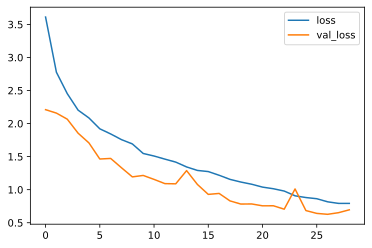

In [154]:
losses[['loss','val_loss']].plot()

In [179]:
train_accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']

train_loss = results.history['loss']
val_loss = results.history['val_loss']

# learning_rate = results.history['learning_rate']

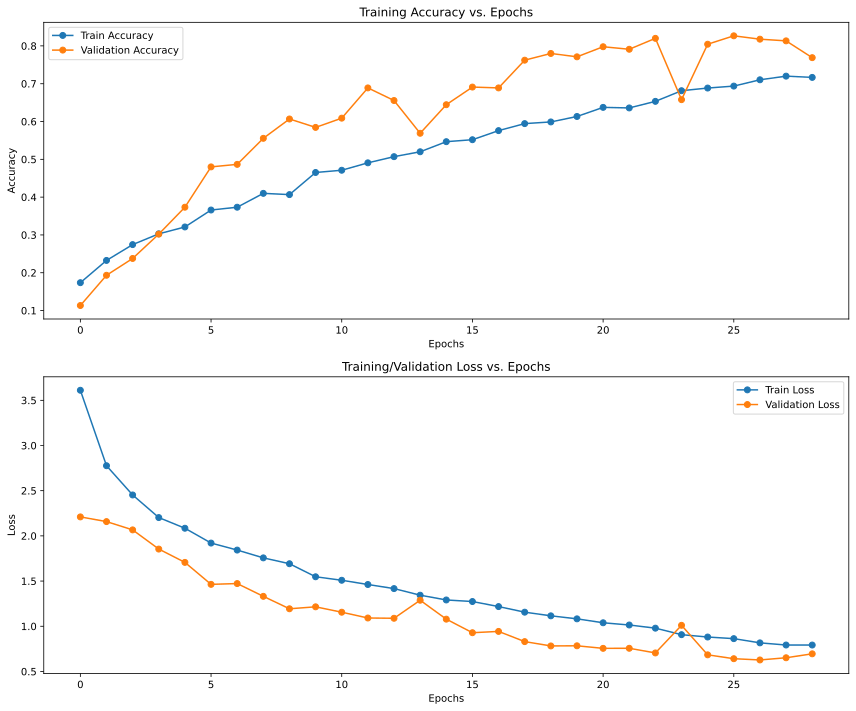

In [181]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [164]:
AlexNetModel.evaluate(test_image_gen)

15/15 [==============================] - 11s 746ms/step - loss: 0.7173 - accuracy: 0.7911


[0.7173304557800293, 0.7911111116409302]

In [158]:
AlexNetModel.metrics_names

['loss', 'accuracy']

In [182]:
pred = AlexNetModel.predict(test_image_gen)

15/15 [==============================] - 12s 776ms/step


In [184]:
labels = {value: key for key, value in train_image_gen.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : aphids
1 : armyworm
2 : beetle
3 : bollworm
4 : grasshopper
5 : mites
6 : mosquito
7 : sawfly
8 : stem_borer


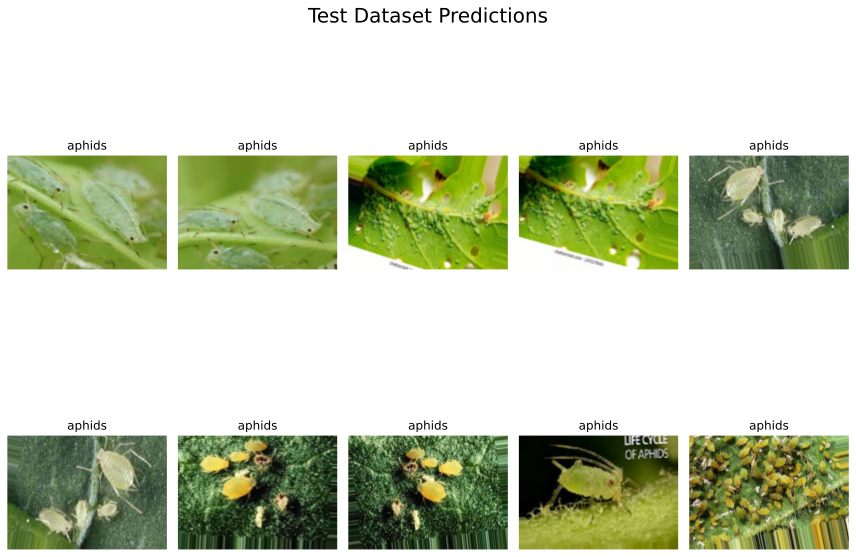

In [185]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(pred[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_image_gen[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [193]:
y_pred = np.argmax(pred, axis = 1)
y_test = test_image_gen.classes

In [194]:
print(classification_report(y_test, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

      aphids       0.81      0.96      0.88        50
    armyworm       0.90      0.76      0.83        50
      beetle       0.60      0.96      0.74        50
    bollworm       0.89      0.68      0.77        50
 grasshopper       0.71      0.84      0.77        50
       mites       0.88      0.72      0.79        50
    mosquito       0.90      0.90      0.90        50
      sawfly       0.91      0.64      0.75        50
  stem_borer       0.76      0.70      0.73        50

    accuracy                           0.80       450
   macro avg       0.82      0.80      0.80       450
weighted avg       0.82      0.80      0.80       450



In [196]:
print(confusion_matrix(y_test, y_pred))

[[48  0  0  0  2  0  0  0  0]
 [ 2 38  2  0  2  1  1  1  3]
 [ 0  0 48  0  1  0  0  0  1]
 [ 2  1  2 34  4  1  2  1  3]
 [ 1  0  4  0 42  0  1  0  2]
 [ 0  1  7  2  2 36  1  0  1]
 [ 0  0  1  0  3  1 45  0  0]
 [ 5  0  7  1  2  2  0 32  1]
 [ 1  2  9  1  1  0  0  1 35]]


In [224]:
new_img = 'Pest/black-beetle-isolated-white-background-macro-56945212.jpg'

In [225]:
my_image = image.load_img(new_img, target_size = IMG_SHAPE)

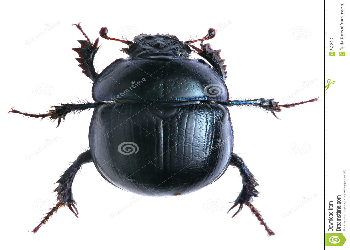

In [226]:
my_image

In [227]:
my_image_array = image.img_to_array(my_image)

In [228]:
my_image_array.shape

(250, 350, 3)

In [229]:
my_image_array = np.expand_dims(my_image_array, axis = 0)

In [230]:
my_image_array.shape

(1, 250, 350, 3)

In [231]:
new_img_pred = AlexNetModel.predict(my_image_array)

1/1 [==============================] - 0s 58ms/step


In [232]:
np.argmax(new_img_pred, axis = 1)

array([2], dtype=int64)

**`-3- Xception Model`**
---------------------------------------

In [32]:
XceptionModel = tf.keras.applications.xception.Xception(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet",
)

for layer in XceptionModel.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        XceptionModel,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(9, activation="softmax"),
    ]
)

model_ft.summary()

model_ft.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 9)                 18441     
                                                                 
Total params: 20,879,921
Trainable params: 20,825,393
Non-trainable params: 54,528
_________________________________________________________________


In [37]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

In [33]:
saveCheckpointsPath = "XceptionPest/improved-{epoch:02d}-{val_accuracy:.2f}.hdf5"
Xceptioncheckpoint = ModelCheckpoint(saveCheckpointsPath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

In [34]:
logXception = CSVLogger("XceptionPestLogs.csv", separator = ',', append = False)

In [35]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
else:
    print('GPU is NOT available')

GPU is available


In [38]:
tf.debugging.set_log_device_placement(True)
with tf.device('/gpu:0'):
    history = model_ft.fit(
        train_image_gen,
        epochs=100,
        callbacks=[early_stop, Xceptioncheckpoint, logXception],
        validation_data=test_image_gen,
        verbose=1,
    )

Epoch 1/100
169/169 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 0.9515
Epoch 1: val_accuracy improved from 0.83111 to 0.90667, saving model to XceptionPest\improved-01-0.91.hdf5
169/169 [==============================] - 92s 543ms/step - loss: 0.1506 - accuracy: 0.9515 - val_loss: 0.3738 - val_accuracy: 0.9067
Epoch 2/100
169/169 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9407
Epoch 2: val_accuracy did not improve from 0.90667
169/169 [==============================] - 98s 580ms/step - loss: 0.1867 - accuracy: 0.9407 - val_loss: 5.1838 - val_accuracy: 0.3333
Epoch 3/100
169/169 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9444
Epoch 3: val_accuracy did not improve from 0.90667
169/169 [==============================] - 106s 627ms/step - loss: 0.1844 - accuracy: 0.9444 - val_loss: 0.4175 - val_accuracy: 0.8844
Epoch 4/100
169/169 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9641


In [39]:
model_ft.save('XceptionPestModel.hdf5')

In [40]:
model_ft.metrics_names

['loss', 'accuracy']

In [41]:
model_ft.evaluate(test_image_gen)

29/29 [==============================] - 7s 251ms/step - loss: 0.7502 - accuracy: 0.8067


[0.7501960396766663, 0.8066666722297668]

In [42]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

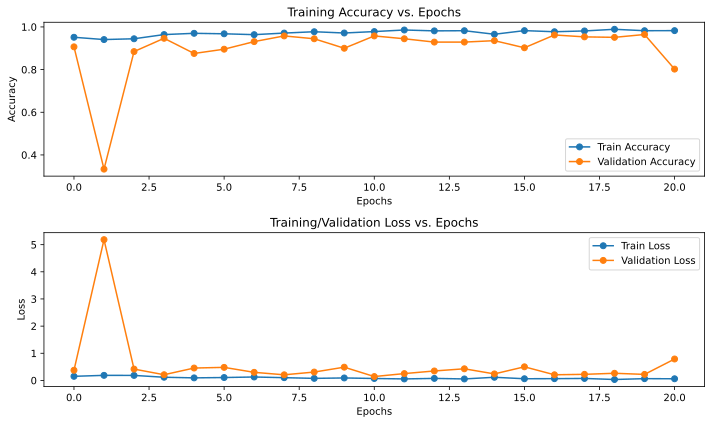

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [45]:
from tensorflow.keras.models import load_model
LoadedModel = load_model('XceptionPest/improved-20-0.96.hdf5')

In [46]:
LoadedModel.evaluate(test_image_gen)

29/29 [==============================] - 8s 247ms/step - loss: 0.2026 - accuracy: 0.9600


[0.20259664952754974, 0.9599999785423279]

In [47]:
df = pd.read_csv('XceptionPestlogs.csv')

In [48]:
train_accuracy = df['accuracy']
val_accuracy = df['val_accuracy']

train_loss = df['loss']
val_loss = df['val_loss']

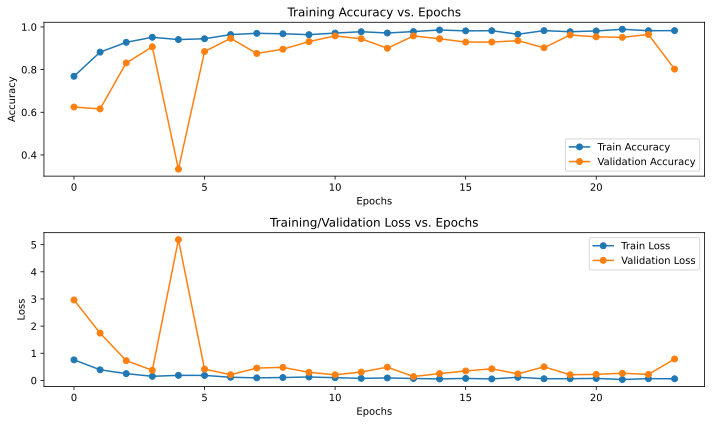

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.savefig('XceptionPlot.png')
plt.show()

In [50]:
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
pred = LoadedModel.predict(test_image_gen)

29/29 [==============================] - 9s 269ms/step


In [52]:
labels = {value: key for key, value in train_image_gen.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : aphids
1 : armyworm
2 : beetle
3 : bollworm
4 : grasshopper
5 : mites
6 : mosquito
7 : sawfly
8 : stem_borer


In [53]:
y_pred = np.argmax(pred, axis = 1)
y_test = test_image_gen.classes

In [54]:
print(classification_report(y_test, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

      aphids       0.98      1.00      0.99        50
    armyworm       0.88      0.98      0.92        50
      beetle       0.98      1.00      0.99        50
    bollworm       0.98      0.94      0.96        50
 grasshopper       0.96      1.00      0.98        50
       mites       1.00      0.86      0.92        50
    mosquito       1.00      1.00      1.00        50
      sawfly       0.94      0.88      0.91        50
  stem_borer       0.92      0.96      0.94        50

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450



<Axes: >

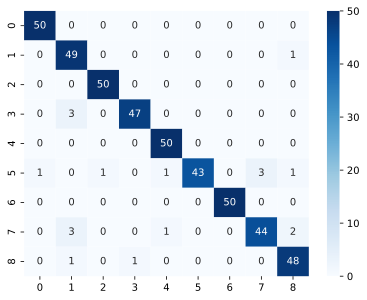

In [55]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, linecolor = 'white', cmap = 'Blues')